# Clasificación de erupciones volcánicas

El presente notebook participa en el JOBMadrid Junior Hackathon, en la modalidad de Data Science. El ejercicio consiste  en la elaboración de un modelo predictivo de clasificación de erupciones volcánicas. El modelo debe basarse en $\textit{Random Forests}$. Los datos se proporcionan en varios ficheros .csv; uno de ellos recoge instancias con features y labels, en el cual se realizará el aprendizaje del modelo, y otro solo features, sobre el cual deberán realizarse las predicciones.


Sin más preambulos, comenzamos con la exposición del trabajo.

## Exportación de librerías.

En primer lugar exportamos las librerías de Python apropiadas para ciencia de datos: $\texttt{numpy}$, para tratamiento numérico y algebraico; $\texttt{pandas}$, para el tratamiento de tablas y series de datos; $\texttt{matplotlib.pyplot}$, para representaciones gráficas; y $\texttt{seaborn}$, para representaciones gráficas de datos avanzadas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exploración de los datos

Todo proyecto de ciencia de datos debe comenzar, al menos, por la exploración de los datos, tanto numérica como visual.

Importamos a continuación el archivo $\textit{jm_train.csv}$ en un DataFrame de $\texttt{pandas}$, que contiene features y labels.

In [2]:
df = pd.read_csv('jm_train.csv')

Ejecutamos varios métodos que nos proporcionan información sobre el dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   target    2100 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 115.0 KB


Observamos que existen 2100 instancias que tienen 6 features con valores reales. No existen valores nulos en el dataset, por lo que no es necesaria la limpieza de estos. También observamos que las features no tienen un nombre o descripción de la medida física que representan. Esto significa que, a efectos de este trabajo, no podemos saber nada de ellas salvo su valor numérico, por lo cual la ingeniería de features estará muy limitada. No podremos utilizar conocimientos sobre geología o vulcanología para ello. Lo único que sabemos es que representan medidas sobre las vibraciones medidas en ciertos puntos de la ladera del volcán.





In [5]:
df.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.204656,0.199249,-0.378140,-0.206425,-0.186419,-0.433229,1.980476
std,1.543613,1.614024,1.450548,1.442225,1.501573,1.188791,1.410537
min,-6.683655,-5.383371,-6.147055,-5.653594,-5.912521,-4.433189,0.000000
25%,-1.171340,-0.877386,-1.365990,-1.259403,-1.211685,-1.131944,1.000000
50%,-0.443868,0.320507,-0.439745,-0.176504,-0.195751,-0.406754,2.000000
75%,0.890023,1.321430,0.662898,0.866879,0.851843,0.348593,3.000000
max,4.565547,6.700133,4.157518,4.371912,5.068783,4.016324,4.000000


Este método da una descripción numérica de las columnas del dataset. Vemos que todas las features tienen una distribución muy parecida, lo que indica que posiblemente han sido escaladas de algún modo. Observamos que también toman valores negativos; debido a nuestro desconocimiento de su significado físico, no podemos inferir si esto tiene sentido o no, aunque a efectos del modelado con Random Forest no tendrá mayores consecuencias. Seguramente sea fruto del proceso de escalado.

In [6]:
df.head()

,feature1,feature2,feature3,feature4,feature5,feature6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


Este es el aspecto que tiene el encabezado del dataset. Observamos la columna $\textit{target}$, que muestra valores enteros. Estos representan las diferentes clases de erupciones: hay 5 clases, tal y como se muestra en la siguiente celda.

In [18]:
print('Clases de erupciones: ',df['target'].unique())
print('Total de clases: ',df['target'].nunique())

Clases de erupciones:  [4 0 1 3 2]
Total de clases:  5


<AxesSubplot:xlabel='target', ylabel='count'>

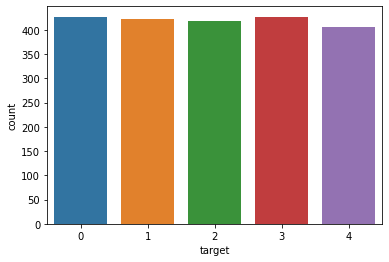

In [24]:
sns.countplot(x=df['target'])

El gráfico muestra la cantidad de instancias pertenecientes a cada clase. Como vemos, todas las clases están representadas de manera bastante equilibrada, lo que facilitará alcanzar un nivel de aprendizaje parecido sobre todas ellas.

$\newline$

A continuación vamos a explorar las distribuciones de las features en mayor profundidad. En primer lugar, representaremos cada distribución por separado.

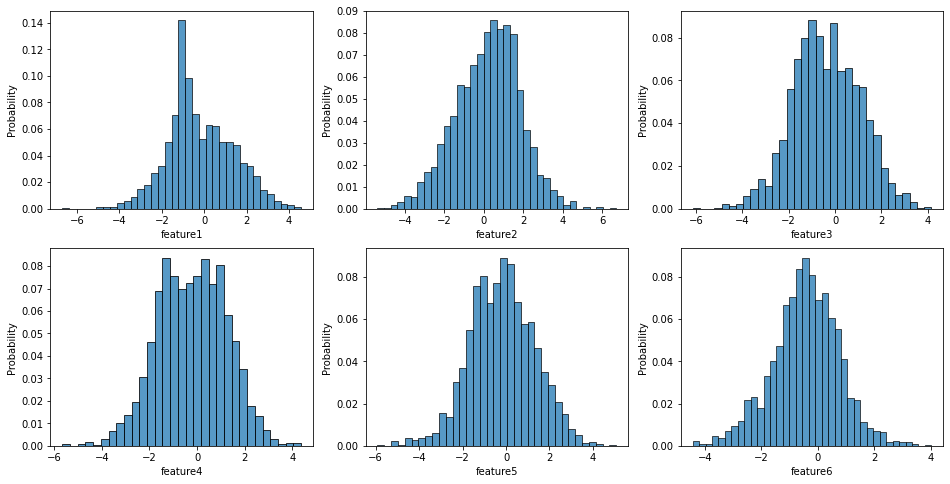

In [33]:
plt.figure(figsize=(16,8));

for i in range(1,7):
    plt.subplot(2,3,i)
    sns.histplot(df,x='feature'+str(i),stat='probability')

Tal y como observamos con el método $\textit{describe}$ anteriormente, las distribuciones son muy similares. Y observamos que tienen una forma aproximadamente gaussiana o normal.

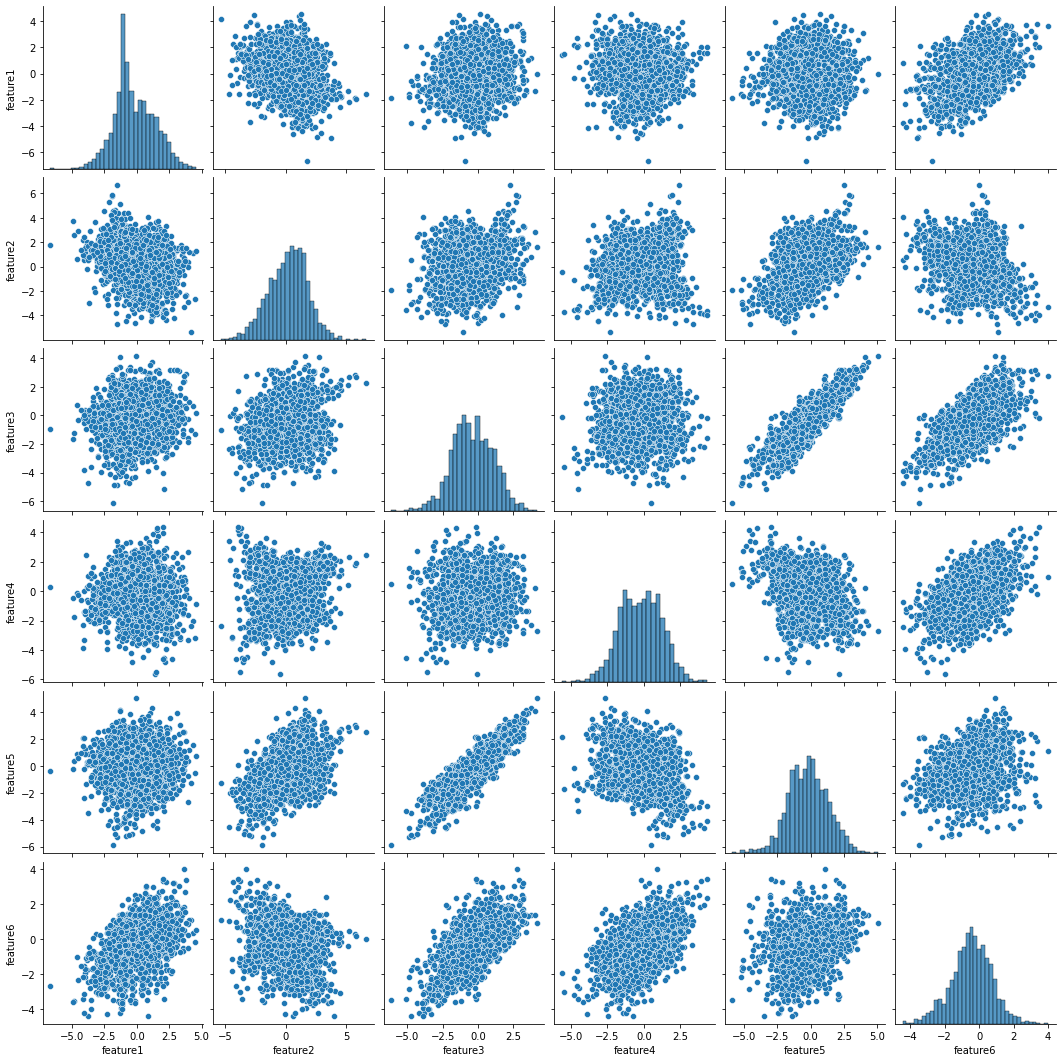

In [29]:
sns.pairplot(df.drop('target',axis=1))

En este gráfico se representan las distribuciones conjuntas por pares de las features. En algunos casos existe una fuerte correlación entre ellas; puede calcularse el coeficiente de correlación para cada par:

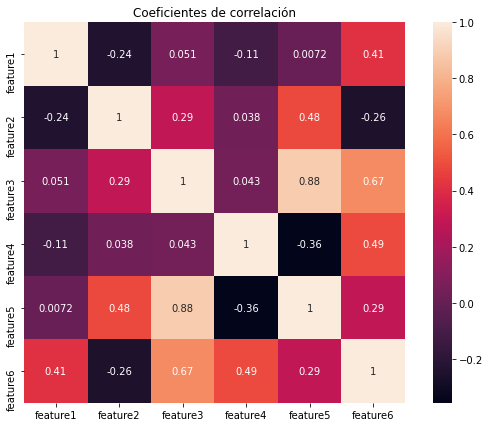

In [3]:
plt.figure(figsize=(10,7))
sns.heatmap(df.drop('target',axis=1).corr(),annot=True,square=True)
plt.title('Coeficientes de correlación');

Por ejemplo, vemos un correlación muy alta entre la feature 3 y la feature 5. Esto puede tener relevancia a la hora de hacer un análisis de componentes principales o $\textit{Principal Component Analysis}$ (PCA), lo cual se estudiará más adelante.


Ahora, realicemos la misma exploración con el dataset $\textit{jm_test.csv}$, que no contiene labels y es con el que se evaluará el poder predictivo del modelo:

In [3]:
df_test = pd.read_csv('jm_X_test.csv')

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  900 non-null    float64
 1   feature2  900 non-null    float64
 2   feature3  900 non-null    float64
 3   feature4  900 non-null    float64
 4   feature5  900 non-null    float64
 5   feature6  900 non-null    float64
dtypes: float64(6)
memory usage: 42.3 KB


In [9]:
df_test.describe()

,feature1,feature2,feature3,feature4,feature5,feature6
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,-0.170339,0.135481,-0.447035,-0.201708,-0.263349,-0.445490
std,1.485402,1.547202,1.394437,1.487102,1.450823,1.215000
min,-5.084203,-4.292548,-4.628992,-6.732089,-5.196997,-4.823971
25%,-1.098759,-0.934171,-1.460497,-1.163163,-1.182667,-1.152891
50%,-0.386297,0.341427,-0.464239,-0.177710,-0.233699,-0.410182
75%,0.881170,1.246296,0.626893,0.870332,0.679282,0.399597
max,4.636012,4.612113,3.299946,5.996929,3.917118,5.357953


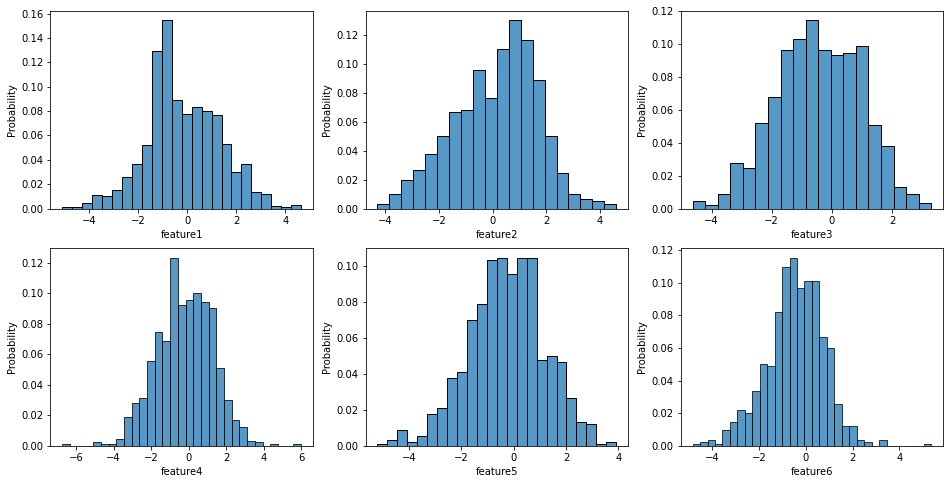

In [12]:
plt.figure(figsize=(16,8));

for i in range(1,7):
    plt.subplot(2,3,i)
    sns.histplot(df_test,x='feature'+str(i),stat='probability')

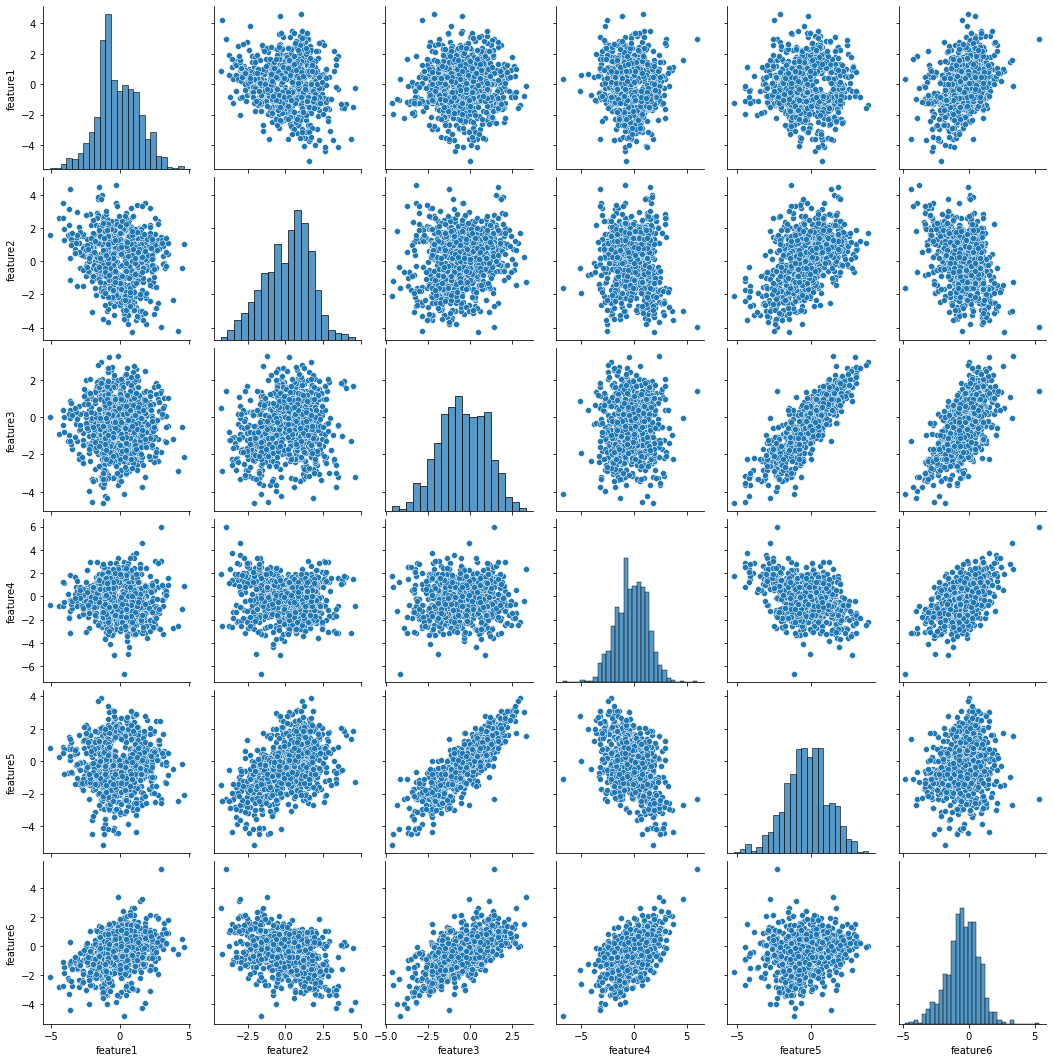

In [13]:
sns.pairplot(df_test)

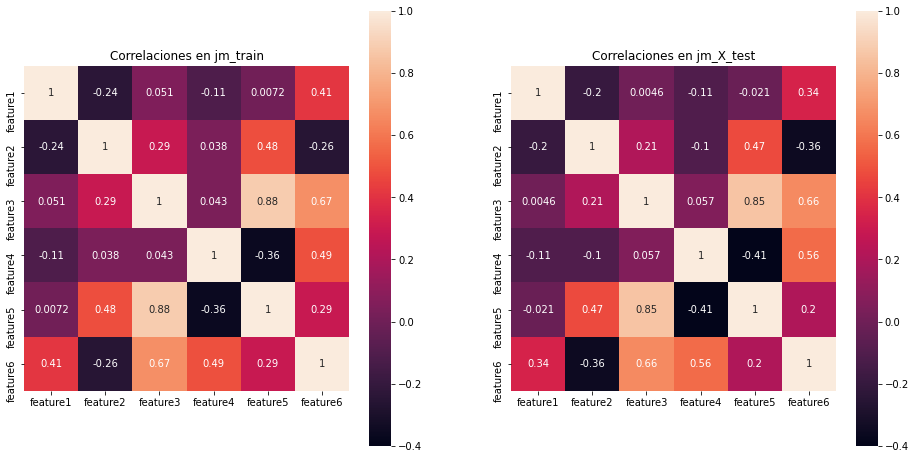

In [23]:
plt.figure(figsize=(16,8));

for i,j,t in zip([df.drop('target',axis=1),df_test],range(1,3),['jm_train','jm_X_test']):
    plt.subplot(1,2,j)
    sns.heatmap(i.corr(),annot=True,square=True,vmin=-0.4,vmax=1)
    plt.title('Correlaciones en '+ t)

En este último gráfico se muestran las dos tablas de correlaciones de los dos datasets, el de entrenamiento y el de evaluación. Junto con el resto de gráficos comprobamos que las distribuciones de las features son muy similares en ambos datasets, por lo que es probable que nuestro modelo pueda generalizar correctamente su aprendizaje.

$\newline$

Pasamos a continuación a las tareas de modelado.

## Modelización

El modelo requerido es $\textit{Random Forest}$. Esta técnica no paramétrica permite realizar tanto regresión como clasificación. En este caso nos interesa la clasificación.

Para implementarla haremos uso de la librería $\textit{scikit-learn}$, una librería de Machine Learning y ciencia de datos con numerosos algoritmos y modelos. Las funciones y métodos necesarios serán importadas en el momento de su uso.

Pero en primer lugar realizaremos una separación de los datos: dividiremos $\textit{jm_train}$ en dos, y dedicaremos una parte al entrenamiento y otra a la evaluación. Esto nos permitirá evaluar nuestro modelo antes de entregar los resultados .

In [4]:
from sklearn.model_selection import train_test_split

X= df.drop('target',axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

Hemos utilizado el método $\textit{train_test_split}$, que realiza una separación de las features y las labels. Hemos fijado una semilla para que X_train y X_test estén fijados a lo largo del trabajo. El tamaño del set de evaluación es de un 30% del total. 

A continuación, importamos el objeto $\textit{RandomForestClassifier}$, que implementa el Random Forest, y creamos una instancia de este.


In [6]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=101)


Ahora es necesario ajustar la instancia a nuestros datos de entrenamiento, para lo cual realizamos la instrucción:

In [9]:
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=101)

Una vez hecho el aprendizaje, es hora de realizar predicciones. Para ello, pasamos las features X_test y guardamos los resultados.

In [10]:
rfc_pred = rfc.predict(X_test)

Para comprobar la bondad del ajuste, importamos diferentes funciones de $\textit{scikit-learn}$: la matriz de confusión y un reporte de métricas, y las ejecutamos con las labels del set de evaluación, $\textit{y_test}$

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred,digits=3))

[[102   6   9   4   4]
 [  9  89   8  15   1]
 [  7   6  86   9  17]
 [  5  10   5 103  16]
 [  2   1   3  10 103]]


              precision    recall  f1-score   support

           0      0.816     0.816     0.816       125
           1      0.795     0.730     0.761       122
           2      0.775     0.688     0.729       125
           3      0.730     0.741     0.736       139
           4      0.730     0.866     0.792       119

    accuracy                          0.767       630
   macro avg      0.769     0.768     0.767       630
weighted avg      0.769     0.767     0.766       630



En la matriz de confusión las filas representan la verdadera clase de una instancia, y las columnas la clase predicha para esa instancia. Las entradas de la matriz representan la cantidad  de instancias clasificadas en cada grupo. Cuanto mayor sea la proporción de instancias en la diagonal de la matriz, mayores serán la $\textit{precision}$, el $\textit{recall}$ y la $\textit{accuracy}$ del modelo, y por tanto su efectividad general.


En el reporte vemos los resultados del $\textit{f1-score}$ para cada clase y el promedio de todas ellas, que será la métrica por la que se evaluará el modelo. Los resultados de este primer modelo no son malos, y en función de los intereses del proyecto en cuestión podrían ser suficientes. Pero tampoco son brillantes, lo que invita a profundizar en el análisis.

Antes de proceder, vamos a obtener una medida más ilustrativa del desempeño de este primer y sencillo algoritmo. El algoritmo Random Forest conlleva una cierta aleatoriedad; el $\textit{f1-score}$ final puede variar en función de esto. Por ello, vamos a promediar los resultados en esta métrica de unos cientos de Random Forest, de manera que tengamos una medida representativa de su performance. Esta será la puntuación base con la que compararemos el resto de métodos


In [12]:
f1_list=[]
items=200
for i in range(items):

    rfc = RandomForestClassifier().fit(X_train,y_train)
    rfc_pred = rfc.predict(X_test)

    f1_list.append(classification_report(y_test,rfc_pred,digits=3,output_dict=True)['macro avg']['f1-score'])
    
    
f1_avg = np.mean(f1_list)
print('f1-score promedio de ',items, ' forests: ',f1_avg)

f1-score promedio de  200  forests:  0.7648667815600468


## Feature engineering

Una de las estrategias habituales para tratar de mejorar el rendimiento de los algoritmos es manipular las features para proporcionar más información al modelo. Sin embargo, en nuestro caso no podemos utilizar conocimientos sobre el ámbito de los datos, ya que las variables son "mudas" y desconocemos su significado. En este escenario será complicado diseñar $\textit{nuevas}$ features con las que enriquecer el modelo. No obstante, haremos algunos intentos.


### Eliminación de features

Pero antes de añadir features consideremos si podemos eliminar algunas. Como hemos visto, existían fuertes correlaciones entre algunas. Esto implica que alguna variable puede ser redundante y no aportar información al modelo. El coeficiente de correlación era especialmente alto en la feature 3; correlacionaba con feature 5 $(0.88)$ y feature 6 $(0.67$). Por tanto, vamos a retirarla de los datos y comprobar qué ocurre con su rendimiento.

In [13]:
X_train_red = X_train.drop('feature3',axis=1)
X_test_red = X_test.drop('feature3',axis=1)

In [333]:
rfc = RandomForestClassifier(random_state=101).fit(X_train_red,y_train)
rfc_pred = rfc.predict(X_test_red)

print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred,digits=3))

[[104   6   7   5   3]
 [  7  90   8  16   1]
 [  5   8  85   9  18]
 [  6  10   3 101  19]
 [  2   1   7   6 103]]


              precision    recall  f1-score   support

           0      0.839     0.832     0.835       125
           1      0.783     0.738     0.759       122
           2      0.773     0.680     0.723       125
           3      0.737     0.727     0.732       139
           4      0.715     0.866     0.783       119

    accuracy                          0.767       630
   macro avg      0.769     0.768     0.767       630
weighted avg      0.769     0.767     0.766       630



En un principio el rendimiento parece idéntico, por lo que no parece afectar ni positiva ni negativamente. De nuevo promediaremos 200 Random forest para tener una medida más representitativa.

In [14]:
f1_list=[]
items= 200
for i in range(items):

    rfc = RandomForestClassifier().fit(X_train_red,y_train)
    rfc_pred = rfc.predict(X_test_red)

    f1_list.append(classification_report(y_test,rfc_pred,digits=3,output_dict=True)['macro avg']['f1-score'])
    
    
f1_avg_2 = np.mean(f1_list)
print('f1-score promedio de ',items, ' forests: ',f1_avg_2)

f1-score promedio de  200  forests:  0.765520236972212


Observamos que el rendimiento es, de hecho, ligeramente superior: $0.7655$ frente a $0.7649$ (resultados que pueden variar con una nueva ejecución de la celda). Por tanto, podemos descartar esa feature sin perjudicar al modelo, lo que supone un ligero ahorro computacional.

### PCA (Principal Component Analysis)

Otra estrategia para tratar altas correlaciones es realizar PCA. PCA es un procedimiento que proyecta sobre dimensiones inferiores un conjunto de datos, de manera que encuentra los hiperplanos con mayor variación en los datos y por tanto, en principio, mayor cantidad de información. Es una manera de reducir la dimensionalidad de los datos, minimizando la perdida de información.

En lugar de eliminar la feature, vamos a realizar un PCA con 5 features, por tanto reduciendo en 1 el total. Esta es una funcionalidad que de nuevo proporciona $\textit{scikit-learn}$.

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

In [16]:
pca.fit(X)

X_pca= pca.transform(X)

X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3,random_state=101)

In [17]:
pd.DataFrame(X_pca_train)

,0,1,2,3,4
0,-2.308811,1.846814,-1.455973,-2.670594,2.542847e-16
1,-1.812925,-1.293487,-0.043188,1.378543,-3.423939e-16
2,-0.318159,-3.261285,0.846583,-1.196100,3.733803e-16
3,-0.196829,0.476040,-1.330452,1.617757,-2.339349e-16
4,1.991510,0.606490,-0.471937,-1.780154,6.059316e-16
...,...,...,...,...,...
1465,0.898729,0.061790,1.731176,-0.667701,9.343918e-17
1466,-2.686231,-0.193571,-0.777667,0.510435,-2.554863e-16
1467,-1.909238,0.853966,-2.103391,0.428351,-2.713155e-16
1468,-2.246708,-0.976904,-0.290880,0.073988,-1.634879e-16


En la celda superior se observa el dataframe con las nuevas features del set de entrenamiento. Como podemos ver, la feature 4 tiene valores muy cercanos a cero, por lo que podemos descartarla al no contener apenas variación. Con las cuatro primeras, procedemos a entrenar el modelo.

In [18]:
X_pca_train = pd.DataFrame(X_pca_train).drop(4,axis=1)
X_pca_test = pd.DataFrame(X_pca_test).drop(4,axis=1)

rfc = RandomForestClassifier(random_state=101).fit(X_pca_train,y_train)
rfc_pred = rfc.predict(X_pca_test)

print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred,digits=3))

[[ 99   8   9   5   4]
 [  8  92   3  18   1]
 [  9   7  82   8  19]
 [  4  14   4 102  15]
 [  2   0   7   9 101]]


              precision    recall  f1-score   support

           0      0.811     0.792     0.802       125
           1      0.760     0.754     0.757       122
           2      0.781     0.656     0.713       125
           3      0.718     0.734     0.726       139
           4      0.721     0.849     0.780       119

    accuracy                          0.756       630
   macro avg      0.758     0.757     0.756       630
weighted avg      0.758     0.756     0.755       630



In [19]:
f1_list=[]
items= 200
for i in range(items):

    rfc = RandomForestClassifier().fit(X_pca_train,y_train)
    rfc_pred = rfc.predict(X_pca_test)

    f1_list.append(classification_report(y_test,rfc_pred,digits=3,output_dict=True)['macro avg']['f1-score'])
    
    
f1_avg_3 = np.mean(f1_list)
print('f1-score promedio de ',items, ' forests: ',f1_avg_3)

f1-score promedio de  200  forests:  0.7506329915085084


Al parecer el análisis no supone una mejora del rendimiento, sino lo contrario. Recordemos que PCA proyecta los datos sobre los hiperplanos óptimos, pero la pérdida de información aún puede ser significativa. Con tan solo 6 features, no parece rentable perder información con este procedimiento.


Descartamos el uso de PCA, pero eliminamos la feature 3, que sí ha probado ser beneficioso (o al menos no perjudicial) para el modelo.

### Creación de features

Pero, ¿y si hubiese más información de la aparente en los datos? Las relaciones entre las features podrían revelar las propiedades esenciales de cada clase. Por ello, vamos a intentar crear nuevas features a partir de relaciones numéricas entre las existentes.

En primer lugar, vamos a crear una nueva feature que será la suma de todas las demás. Cada feature representa vibraciones, por lo que quizá la vibración total esté relacionada con la pertenencia a una clase. Procedamos a ello y a entrenar el modelo.

In [20]:
X= df.drop(['target','feature3'],axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

In [341]:
feat = X.copy()
feat['total'] = X.sum(axis=1)

X_train_tot, X_test_tot, y_train, y_test = train_test_split(feat, y, test_size=0.3,random_state=101)

In [342]:
rfc = RandomForestClassifier(random_state=101).fit(X_train_tot,y_train)
rfc_pred = rfc.predict(X_test_tot)

print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred,digits=3))

[[101   8   8   4   4]
 [  7  91   7  16   1]
 [  7   7  83  10  18]
 [  4  11   6 100  18]
 [  3   1   6   7 102]]


              precision    recall  f1-score   support

           0      0.828     0.808     0.818       125
           1      0.771     0.746     0.758       122
           2      0.755     0.664     0.706       125
           3      0.730     0.719     0.725       139
           4      0.713     0.857     0.779       119

    accuracy                          0.757       630
   macro avg      0.759     0.759     0.757       630
weighted avg      0.759     0.757     0.756       630



Vemos que la nueva feature no mejora el rendimiento en un único Random Forest, por lo que no nos molestaremos en hacer un promedio.


Vayamos con otra idea. Es posible que los ratios entre features sean relevantes, la cantidad de vibración de una medida respecto a las demás. Por ello, vamos a crear estas nuevas variables: todas las combinaciones de cocientes entre las feautures. En total, serán 10 nuevas features

In [343]:
new_feats = X.copy()

for i in range(5):
    for j in range(i+1,5):
        new_feats[X.iloc[:,i].name+ '/' + X.iloc[:,j].name] = X.iloc[:,i]/X.iloc[:,j]
        
new_feats

,feature1,feature2,feature4,feature5,feature6,feature1/feature2,feature1/feature4,feature1/feature5,feature1/feature6,feature2/feature4,feature2/feature5,feature2/feature6,feature4/feature5,feature4/feature6,feature5/feature6
0,0.474335,0.881640,-1.251935,-1.035151,-1.934367,0.538014,-0.378881,-0.458228,-0.245214,-0.704222,-0.851702,-0.455777,1.209423,0.647207,0.535137
1,-1.034675,1.741801,-1.555989,-0.337553,-2.473838,-0.594026,0.664963,3.065228,0.418247,-1.119417,-5.160088,-0.704089,4.609619,0.628978,0.136449
2,-0.563221,-0.688381,-1.845172,0.352366,-0.912928,0.818182,0.305240,-1.598397,0.616939,0.373071,-1.953594,0.754036,-5.236516,2.021157,-0.385974
3,-1.268179,2.770688,2.830389,0.395093,0.677715,-0.457712,-0.448058,-3.209824,-1.871258,0.978907,7.012753,4.088282,7.163857,4.176373,0.582978
4,-1.216380,-0.391267,-0.913074,-2.171857,-2.367490,3.108821,1.332181,0.560065,0.513785,0.428516,0.180153,0.165267,0.420412,0.385672,0.917367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,-0.947002,0.174969,0.118236,-0.143420,-0.359509,-5.412409,-8.009394,6.602999,2.634156,1.479821,-1.219974,-0.486688,-0.824407,-0.328883,0.398933
2096,-1.224148,0.029956,0.888406,0.119460,0.378946,-40.864618,-1.377914,-10.247312,-3.230399,0.033719,0.250762,0.079051,7.436827,2.344412,0.315244
2097,-0.847593,1.538574,1.966467,0.379934,0.737907,-0.550895,-0.431023,-2.230893,-1.148645,0.782405,4.049577,2.085050,5.175806,2.664924,0.514881
2098,1.472437,1.187695,-1.103522,1.586722,0.182569,1.239743,-1.334307,0.927974,8.065105,-1.076277,0.748521,6.505463,-0.695472,-6.044413,8.691089


In [345]:
X_train_nf, X_test_nf, y_train, y_test = train_test_split(new_feats, y, test_size=0.3,random_state=101)


rfc = RandomForestClassifier().fit(X_train_nf,y_train)
rfc_pred = rfc.predict(X_test_nf)

print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred,digits=3))

[[102   6   8   5   4]
 [ 10  89   8  15   0]
 [  8   8  85   6  18]
 [  1  17  11  92  18]
 [  2   1  11   6  99]]


              precision    recall  f1-score   support

           0      0.829     0.816     0.823       125
           1      0.736     0.730     0.733       122
           2      0.691     0.680     0.685       125
           3      0.742     0.662     0.700       139
           4      0.712     0.832     0.767       119

    accuracy                          0.741       630
   macro avg      0.742     0.744     0.742       630
weighted avg      0.742     0.741     0.740       630



Como vemos, la creación de estas features no revela ninguna información y empeora el modelo, por lo que descartamos este procedimiento. Con esto damos por concluido el proceso de ingeniería de features.

## Otros algoritmos

Para saber si el rendimiento de nuestro modelo es bueno puede ser útil compararlo con otros algoritmos. En esta sección compararemos el Random Forest con otros tres modelos: $\textit{Decision Tree}$, $\textit{K-Nearest Neighbours}$ y una $\textit{red neuronal}$  

### Decision Tree

Un árbol de decisión es, de hecho, la base del algoritmo Random Forest, pues este no es más que la agregación de muchos árboles de decisión. El árbol de decisión genera una serie de nodos, que son regiones del espacio de las features. Estos nodos se optimizan para tener la máxima pureza posible, es decir, que cada nodo tenga mayoritariamente una única clase. Para ello el árbol genera separaciones en el espacio de features probando diferentes valores de estas y seleccionando la segmentación que genera una mayor disminución en una cierta métrica, como el coeficiente Gini, relacionada con la pureza. Cuando el modelo predice la clase de una nueva instancia, adjudica la instancia al nodo correspondiente según sus features, y predice que esta instancia tendrá la clase más representada en ese nodo.

En principio un árbol de decisión debería tener un desempeño siempre menor al de un Random Forest, pues este agrega las predicciones de muchos árboles distintos. No obstante, vamos a comprobar si es realmente así en este caso.

In [346]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=101).fit(X_train,y_train)
dtc_pred = dtc.predict(X_test)

print(confusion_matrix(y_test,dtc_pred))
print('\n')
print(classification_report(y_test,dtc_pred,digits=3))

[[90 10 15  6  4]
 [12 78 13 16  3]
 [ 9 12 83  7 14]
 [10 18  5 89 17]
 [ 3  0 23 10 83]]


              precision    recall  f1-score   support

           0      0.726     0.720     0.723       125
           1      0.661     0.639     0.650       122
           2      0.597     0.664     0.629       125
           3      0.695     0.640     0.667       139
           4      0.686     0.697     0.692       119

    accuracy                          0.671       630
   macro avg      0.673     0.672     0.672       630
weighted avg      0.673     0.671     0.672       630



Como era de esperar, el árbol de decisión predice mucho peor que el Random Forest. Pasemos a otros modelos con mayor interés.

### K-nearest neighbours 

Este algoritmo clasifica las instancias según su cercanía en el espacio de las features a las instancias del dataset. Al recibir una nueva instancia el algoritmo encuentra las k instancias más cercanas a la nueva instancia en el set de entrenamiento , y la clasifica según la clase mayoritaria en estos k vecinos. La cercanía puede definirse con distintas métricas de la distancia, por ejemplo, la distancia euclídea en el espacio f-dimensional de las features, si f es el número de features.

Procedamos a entrenar este modelo y observemos sus resultados.

In [347]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier().fit(X_train,y_train)

pred = knn.predict(X_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred,digits=3))

[[103   9   5   6   2]
 [  8  95   4  15   0]
 [ 10  14  80   6  15]
 [  5  16   6  99  13]
 [  4   1   8   8  98]]
              precision    recall  f1-score   support

           0      0.792     0.824     0.808       125
           1      0.704     0.779     0.739       122
           2      0.777     0.640     0.702       125
           3      0.739     0.712     0.725       139
           4      0.766     0.824     0.794       119

    accuracy                          0.754       630
   macro avg      0.755     0.756     0.754       630
weighted avg      0.755     0.754     0.753       630



El rendimiento se acerca al del Random Forest, pero no lo mejora. Este algoritmo tiene un único hiperparámetro que optimizar, el número k. En este caso se ha utilizado el número por defecto $k=5$, pero puede hacerse un sencillo análisis para optimizar este parámetro. Por ello, en la siguiente celda se prueban todos los posibles valores desde $k=1$ hasta $k=50$, y se evalúa el f1-score en cada caso. Después seleccionamos el valor k óptimo y reentrenamos al modelo.

Text(0, 0.5, 'Macro f1')

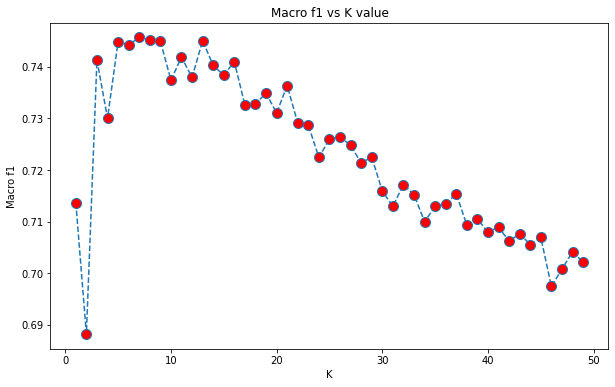

In [348]:
from sklearn.model_selection import cross_val_score

error_rate = []

for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    error_rate.append(np.mean(cross_val_score(knn, X_train, y_train, cv=6,scoring='f1_macro')))

    
plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Macro f1 vs K value')
plt.xlabel('K') ; plt.ylabel('Macro f1')

Para este análisis se ha realizado una técnica llamada $\textit{cross validation}$, que resulta adecuada en la optimización de hiperparámetros. Los detalles sobre ella serán explicados más adelante.

Como vemos en la gráfica, el valor mayor de f1 se encuentra en $k=7$. Probemos este valor para ver cómo afecta a los resultados.

In [349]:
knn = KNeighborsClassifier(n_neighbors=7).fit(X_train,y_train)

pred = knn.predict(X_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred,digits=3))

[[103   8   5   6   3]
 [  9  92   4  17   0]
 [ 11  15  77   5  17]
 [  5  15   4 102  13]
 [  5   1   5   7 101]]
              precision    recall  f1-score   support

           0      0.774     0.824     0.798       125
           1      0.702     0.754     0.727       122
           2      0.811     0.616     0.700       125
           3      0.745     0.734     0.739       139
           4      0.754     0.849     0.798       119

    accuracy                          0.754       630
   macro avg      0.757     0.755     0.753       630
weighted avg      0.757     0.754     0.752       630



El rendimiento es prácticamente idéntico. En general KNN desempeña algo peor que Random Forest, lo que nos sirve para reforzar nuestra confianza en la elección de este último.

### Red neuronal prealimentada (feedforward)

Una red neuronal es un conjunto de neuronas, que funcionan como una cierta función matemática, dispuestas en capas interconectadas cuya respuesta está determinada por una serie de parámetros. Estos parámetros, a menudo llamados $\textit{pesos}$, pueden optimizarse para que la respuesta de la red sea predictiva respecto a unos ciertos datos. El entrenamiento puede realizarse con algoritmos como $\textit{gradient descent}$ y $\textit{backpropagation}$. 

Las redes neuronales aprenden del set de entrenamiento, optimizando poco a poco sus parámetros. Es una técnica muy poderosa, pues jugar con el número de neuronas y las capas otorga mucha flexibilidad al modelo, aunque debe velarse por no incurrir en $\textit{overfitting}$.

Para implementar este modelo utilizaremos una nueva librería, $\textit{tensorflow}$

In [350]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [351]:
model = Sequential([
    Dense(5,activation='relu'),
    Dense(20, activation='relu'),
    Dense(5, activation='softmax')])


model.compile(optimizer="adam", loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [352]:
model.fit(x=X_train, y=y_train, validation_data=(X_test,y_test), epochs=600, verbose=1)

Epoch 1/600
46/46 [==============================] - 0s 3ms/step - loss: 1.7626 - accuracy: 0.1956 - val_loss: 1.5936 - val_accuracy: 0.2349
Epoch 2/600
46/46 [==============================] - 0s 1ms/step - loss: 1.5820 - accuracy: 0.2585 - val_loss: 1.4855 - val_accuracy: 0.2968
Epoch 3/600
46/46 [==============================] - 0s 1ms/step - loss: 1.4519 - accuracy: 0.3190 - val_loss: 1.4141 - val_accuracy: 0.3730
Epoch 4/600
46/46 [==============================] - 0s 1ms/step - loss: 1.3771 - accuracy: 0.4159 - val_loss: 1.3651 - val_accuracy: 0.3905
Epoch 5/600
46/46 [==============================] - 0s 1ms/step - loss: 1.3418 - accuracy: 0.3966 - val_loss: 1.3269 - val_accuracy: 0.4333
Epoch 6/600
46/46 [==============================] - 0s 1ms/step - loss: 1.2907 - accuracy: 0.4452 - val_loss: 1.2971 - val_accuracy: 0.4571
Epoch 7/600
46/46 [==============================] - 0s 1ms/step - loss: 1.2729 - accuracy: 0.4661 - val_loss: 1.2683 - val_accuracy: 0.4635
Epoch 8/600
4

Epoch 59/600
46/46 [==============================] - 0s 1ms/step - loss: 0.7115 - accuracy: 0.7267 - val_loss: 0.7490 - val_accuracy: 0.6921
Epoch 60/600
46/46 [==============================] - 0s 1ms/step - loss: 0.7115 - accuracy: 0.7308 - val_loss: 0.7493 - val_accuracy: 0.6984
Epoch 61/600
46/46 [==============================] - 0s 1ms/step - loss: 0.6812 - accuracy: 0.7326 - val_loss: 0.7457 - val_accuracy: 0.7000
Epoch 62/600
46/46 [==============================] - 0s 1ms/step - loss: 0.6922 - accuracy: 0.7369 - val_loss: 0.7482 - val_accuracy: 0.7032
Epoch 63/600
46/46 [==============================] - 0s 1ms/step - loss: 0.7136 - accuracy: 0.7405 - val_loss: 0.7431 - val_accuracy: 0.7000
Epoch 64/600
46/46 [==============================] - 0s 1ms/step - loss: 0.6852 - accuracy: 0.7276 - val_loss: 0.7444 - val_accuracy: 0.7063
Epoch 65/600
46/46 [==============================] - 0s 1ms/step - loss: 0.7259 - accuracy: 0.7325 - val_loss: 0.7405 - val_accuracy: 0.7048
Epoch 

46/46 [==============================] - 0s 1ms/step - loss: 0.6159 - accuracy: 0.7666 - val_loss: 0.7003 - val_accuracy: 0.7127
Epoch 174/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5943 - accuracy: 0.7709 - val_loss: 0.6978 - val_accuracy: 0.7190
Epoch 175/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5944 - accuracy: 0.7661 - val_loss: 0.6962 - val_accuracy: 0.7159
Epoch 176/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5942 - accuracy: 0.7604 - val_loss: 0.6983 - val_accuracy: 0.7143
Epoch 177/600
46/46 [==============================] - 0s 1ms/step - loss: 0.6231 - accuracy: 0.7587 - val_loss: 0.7009 - val_accuracy: 0.7206
Epoch 178/600
46/46 [==============================] - 0s 1ms/step - loss: 0.6353 - accuracy: 0.7557 - val_loss: 0.6977 - val_accuracy: 0.7127
Epoch 179/600
46/46 [==============================] - 0s 1ms/step - loss: 0.6035 - accuracy: 0.7624 - val_loss: 0.6986 - val_accuracy: 0.7175
Epoch 180/600

46/46 [==============================] - 0s 1ms/step - loss: 0.5669 - accuracy: 0.7803 - val_loss: 0.6989 - val_accuracy: 0.7206
Epoch 288/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5456 - accuracy: 0.7948 - val_loss: 0.6962 - val_accuracy: 0.7190
Epoch 289/600
46/46 [==============================] - 0s 1ms/step - loss: 0.6026 - accuracy: 0.7792 - val_loss: 0.6979 - val_accuracy: 0.7206
Epoch 290/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5936 - accuracy: 0.7817 - val_loss: 0.6976 - val_accuracy: 0.7190
Epoch 291/600
46/46 [==============================] - 0s 1ms/step - loss: 0.6290 - accuracy: 0.7771 - val_loss: 0.6974 - val_accuracy: 0.7206
Epoch 292/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5824 - accuracy: 0.7796 - val_loss: 0.6957 - val_accuracy: 0.7238
Epoch 293/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5577 - accuracy: 0.7764 - val_loss: 0.6951 - val_accuracy: 0.7238
Epoch 294/600

46/46 [==============================] - 0s 1ms/step - loss: 0.5597 - accuracy: 0.7782 - val_loss: 0.6985 - val_accuracy: 0.7381
Epoch 402/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5841 - accuracy: 0.7661 - val_loss: 0.7051 - val_accuracy: 0.7238
Epoch 403/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5712 - accuracy: 0.7930 - val_loss: 0.7017 - val_accuracy: 0.7302
Epoch 404/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5539 - accuracy: 0.7841 - val_loss: 0.7071 - val_accuracy: 0.7254
Epoch 405/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5514 - accuracy: 0.7791 - val_loss: 0.7018 - val_accuracy: 0.7365
Epoch 406/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5661 - accuracy: 0.7748 - val_loss: 0.7008 - val_accuracy: 0.7365
Epoch 407/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5382 - accuracy: 0.7913 - val_loss: 0.7049 - val_accuracy: 0.7270
Epoch 408/600

46/46 [==============================] - 0s 1ms/step - loss: 0.5183 - accuracy: 0.7972 - val_loss: 0.7047 - val_accuracy: 0.7333
Epoch 516/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5280 - accuracy: 0.7881 - val_loss: 0.7023 - val_accuracy: 0.7333
Epoch 517/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5373 - accuracy: 0.8110 - val_loss: 0.7034 - val_accuracy: 0.7381
Epoch 518/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5492 - accuracy: 0.7820 - val_loss: 0.7027 - val_accuracy: 0.7397
Epoch 519/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5771 - accuracy: 0.7769 - val_loss: 0.7130 - val_accuracy: 0.7333
Epoch 520/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5449 - accuracy: 0.7867 - val_loss: 0.7050 - val_accuracy: 0.7381
Epoch 521/600
46/46 [==============================] - 0s 1ms/step - loss: 0.5376 - accuracy: 0.7946 - val_loss: 0.7063 - val_accuracy: 0.7286
Epoch 522/600

In [353]:
pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test,pred,digits=3))

              precision    recall  f1-score   support

           0      0.817     0.784     0.800       125
           1      0.729     0.770     0.749       122
           2      0.729     0.624     0.672       125
           3      0.740     0.655     0.695       139
           4      0.695     0.882     0.778       119

    accuracy                          0.740       630
   macro avg      0.742     0.743     0.739       630
weighted avg      0.742     0.740     0.737       630



El desempeño de la red es inferior al de Random Forest. 


Al haber comparado Random Forest con otros modelos y comprobado que sus resultados prevalecen, podemos cerciorarnos de que el modelo es adecuado para el problema y, además, que aprovecha de manera óptima la información presente en el dataset, pues tanto la red neuronal como KNN no son capaces de extraer más información. Junto con los intentos de ingeniería de features, esto nos muestra que hemos hecho cerca de todo lo posible en cuanto al tratamiento del dataset.

Sin embargo, aún queda camino por recorrer, pues no hemos abordado (salvo brevemente para KNN) la optimización de hiperparámetros. Si no puede mejorarse el dataset, deberá abordarse la mejora del método. En esto consistirá la siguiente sección.

## Optimización del Random Forest

Los algoritmos en ciencia de datos suelen estar regulados por parámetros que no son susceptibles de ser optimizados directamente a partir de los datos. A estos se les suele llamar hiperparámetros.

Para encontrar estos valores óptimos se debe probar el rendimiento del algoritmo cambiando los valores de estos parámetros y comparando el desempeño. No existe, en general, un algoritmo directo para optimizarlos, salvo probar cada valor por separado y observar los resultados.

Pero sí existen algunas técnicas que facilitan este proceso. Una de ellas es la llamada $\textit{cross validation}$. A la hora de probar diferentes hiperparámetros los resultados se evalúan en el test set. Pero al hacerlo se corre el riesgo de estar optimizando esos parámetros $\textit{para}$ ese test set en concreto, empobreciendo el funcionamiento futuro del modelo. Por ello se utiliza esta técnica.

Consiste en dividir el training set en n partes iguales seleccionadas aleatoriamente, que representamos con el índice $i$. El modelo se evalúa en la parte $i=1$, que hace las funciones de test set, habiéndose entrenado en el resto de partes. Después, se evalúa en la parte $i=2$, habiéndose entrando en las restantes. Así hasta llegar a $i=n$, es decir, se repite el proceso $n$ veces. Se producen por tanto $n$ métricas (en nuestro caso, el f1-score macro), por lo que se toma el promedio de ellas, y ese es el resultado del modelo para el valor del hiperparámetro que estemos estudiando. A continuación se repite el proceso con otro valor del hiperparámetro, y así sucesivamente.

Con este procedimiento se evita sesgar los hiperparámetros a un conjunto de datos concreto.

Para cada valor del hiperparámetro realizaremos el proceso de cross validation varias veces y promediaremos los resultados, controlando así la aleatoriedad intrínseca del Random Forest

### Hiperparámetros de un Random Forest

#### n_estimators

El primer parámetro que puede considerarse es el número de árboles de decisión que conforman el forest. En principio el rendimiento tiende a mejorar indefinidamente según aumenta este número, pero llega un punto en que el crecimiento se hace extremadamente lento o prácticamente se estabiliza. Por ello, y teniendo en cuanta que según aumenta este número también lo hace el coste computacional, es deseable encontar este punto de estabilización y no excederlo.

Realizamos ahora el procedimiento de cross validation, dividiendo el training set en 6 partes, y probando desde $n=100$ hasta $n=300$ para el número de árboles. Generamos una gráfica que representa el f1-score macro para cada valor. El tiempo de ejecución de la celda puede ser considerable, por lo que se va imprimiendo por pantalla el progreso.

In [368]:
mean_scores_nestimators=[]

steps= 300

for i in range(100,steps+1,10):
    int_list= []
    for j in range(5):
        rfc = RandomForestClassifier(n_estimators=i)
        int_list.append(np.mean(cross_val_score(rfc, X_train, y_train, cv=6,scoring='f1_macro')))
        
    mean_scores_nestimators.append(np.mean(int_list))
    print('Va por el forest de ', str(i), ' árboles')

Va por el forest de  100  árboles
Va por el forest de  110  árboles
Va por el forest de  120  árboles
Va por el forest de  130  árboles
Va por el forest de  140  árboles
Va por el forest de  150  árboles
Va por el forest de  160  árboles
Va por el forest de  170  árboles
Va por el forest de  180  árboles
Va por el forest de  190  árboles
Va por el forest de  200  árboles
Va por el forest de  210  árboles
Va por el forest de  220  árboles
Va por el forest de  230  árboles
Va por el forest de  240  árboles
Va por el forest de  250  árboles
Va por el forest de  260  árboles
Va por el forest de  270  árboles
Va por el forest de  280  árboles
Va por el forest de  290  árboles
Va por el forest de  300  árboles


Text(0, 0.5, 'Mean f1 Score')

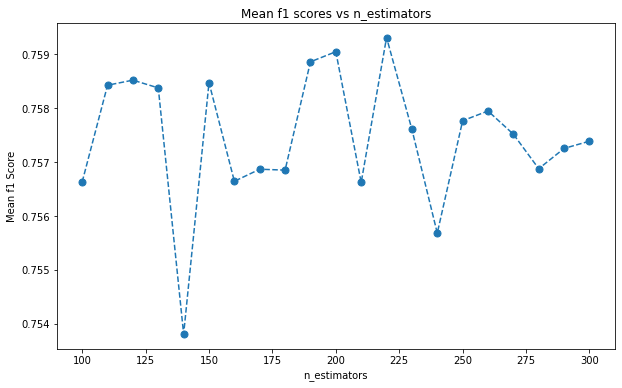

In [369]:
plt.figure(figsize=(10,6))
plt.plot(range(100,steps+1,10),mean_scores_nestimators,linestyle='dashed',marker='o',markersize=7)
plt.title('Mean f1 scores vs n_estimators')
plt.xlabel('n_estimators') ; plt.ylabel('Mean f1 Score')

La puntuación parece bastante estable en el intervalo, aunque parece estabilizarse a partir de $n=250$. Nos quedaremos con este valor de ahora en adelante.

#### Cost complexity pruning,  parámetro $\alpha$ 

Una de las técnicas que pueden aplicarse a los Random Forest es una llamada $\textit{cost complexity pruning}$. Consiste en "podar" los nodos terminales de los de los árboles, deshaciendo en cierta medida la construcción del árbol. Esta técnica ayuda a combatir el $\textit{overfitting}$, pues el árbol puede sobreajustar los datos de entrenamiento de manera que generalice pobremente a los datos del test set. Esto se logra mponiendo un coste al número de nodos total del árbol, contando también los nodos internos, ya que a mayor número de nodos mayor riesgo de overfitting.

Este coste está regulado por el parámetro $\alpha$. Haciendo pruebas preliminares hemos comprobado que valores altos de $\alpha$ generan malos resultados, por lo que comenzamos con valores de diezmilésimas el proceso de cross validation.

In [374]:
mean_scores_alpha=[]

steps= 20

for i in range(steps):
    int_list =[]
    for j in range(10):
        rfc = RandomForestClassifier(n_estimators=50,ccp_alpha=0.0 +i*5e-5)
        int_list.append(np.mean(cross_val_score(rfc, X_train, y_train, cv=6,scoring='f1_macro')))
    
    mean_scores_alpha.append(np.mean(int_list))
    print('va por el paso', i,'/',steps)

va por el paso 0 / 20
va por el paso 1 / 20
va por el paso 2 / 20
va por el paso 3 / 20
va por el paso 4 / 20
va por el paso 5 / 20
va por el paso 6 / 20
va por el paso 7 / 20
va por el paso 8 / 20
va por el paso 9 / 20
va por el paso 10 / 20
va por el paso 11 / 20
va por el paso 12 / 20
va por el paso 13 / 20
va por el paso 14 / 20
va por el paso 15 / 20
va por el paso 16 / 20
va por el paso 17 / 20
va por el paso 18 / 20
va por el paso 19 / 20


Text(0, 0.5, 'Mean Score')

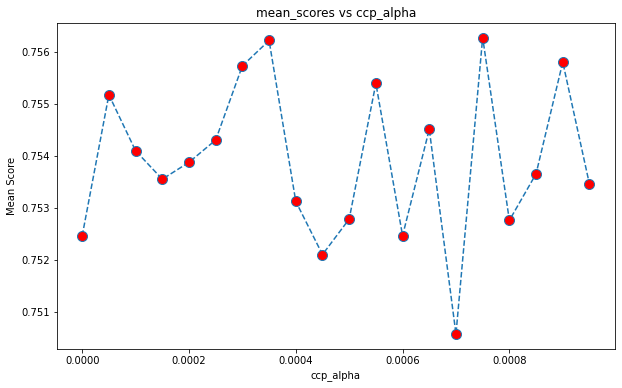

In [375]:
plt.figure(figsize=(10,6))
plt.plot(np.linspace(0.0000,5e-5*(steps-1),steps),mean_scores_alpha,linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('mean_scores vs ccp_alpha')
plt.xlabel('ccp_alpha') ; plt.ylabel('Mean Score')

Desafortunadamente no se aprecia una tendencia clara en este parámetro, sino fuertes oscilaciones, por lo que hemos decidido mantenerlo a 0. 

#### max_features

La cualidad distintiva de un Random Forest que diferencia a los árboles que lo integran es que en cada paso para la creación de nodos internos no consideran todas las features y seleccionan la segmentación óptima (que viene definida por su reducción de alguna métrica como el coeficiente Gini), sino que sólo consideran una fracción del total elegida aleatoriamente. El árbol de decisión se construye por un algoritmo $\textit{greedy}$, es decir, no busca la solución globalmente óptima, lo que sería demasiado costoso computacionalmente, si no que a cada paso construye la mejor solución disponible. Recordemos que un árbol de decisión trata de optimizar la pureza de sus nodos terminales. 

Mediante esta selección aleatoria de features a cada paso, es probable que alguno de los árboles encuentre, en diferentes partes de su construcción, el paso globalmente óptimo. Al promediar todos los árboles se logra una medida más exacta. También puede pensarse que este proceso hace que los árboles estén menos correlacionados; al promediarlos se logra una disminución en la varianza mayor que en el caso de que estuviesen correlacionados, lo cual ocurriría con toda seguridad ya que todos se construyen de manera $\textit{greedy}$.

Por ello, el número de features a considerar en cada paso puede variar entre 1 y el número total de features. En nuestro caso, al contar tan solo con 5 features, será muy rápido optimizar este valor.

va por el paso  1 / 5
va por el paso  2 / 5
va por el paso  3 / 5
va por el paso  4 / 5
va por el paso  5 / 5


Text(0, 0.5, 'Mean f1 Score')

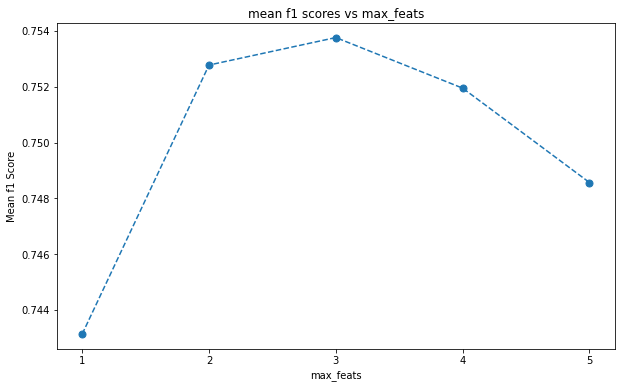

In [376]:
mean_scores_nfeats=[]

feats=5

for i in range(1,feats+1):
    print('va por el paso ', i,'/',feats)
    internal_list= []
    for j in range(10):
        rfc = RandomForestClassifier(n_estimators=50,max_features=i,)
        internal_list.append(np.mean(cross_val_score(rfc, X_train, y_train, cv=6,scoring='f1_macro')))
    
    mean_scores_nfeats.append(np.mean(internal_list))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,feats+1),mean_scores_nfeats,linestyle='dashed',marker='o',markersize=7)
plt.xticks(range(1,feats+1))
plt.title('mean f1 scores vs max_feats')
plt.xlabel('max_feats') ; plt.ylabel('Mean f1 Score')    

Vemos que los resultados son mejores para $max feats = 3$, aunque el valor 2 es bastante cercano, lo cual reivindica la convención de que este parámetro suele optimizarse cuando $max feats \approx\sqrt{f}$ siendo $f$ el total de features.

## Modelo final

Tras la optimización de los hiperparámetros a estos valores: n_estimators $= 247$, $\alpha=0$, max_feat$=3$. Creamos una instancia con estos valores y comparamos sus resultados con la instancia no optimizada del principio del notebook.

In [21]:
f1_list=[]
items=100
for i in range(items):

    rfc = RandomForestClassifier(n_estimators=250,max_features=3,ccp_alpha=0.0).fit(X_train,y_train)
    rfc_pred = rfc.predict(X_test)

    f1_list.append(classification_report(y_test,rfc_pred,digits=3,output_dict=True)['macro avg']['f1-score'])
    
    
f1_avg_final = np.mean(f1_list)
print('f1-score promedio de ',items, ' forests: ',f1_avg_final)

f1-score promedio de  100  forests:  0.7690174736450885


El rendimiento ha mejorado unas decimas porcentuales, pues recordamos que la puntuación del Random Forest no optimizado era:


In [22]:
print('f1-score promedio sin optimizar',f1_avg)

f1-score promedio sin optimizar 0.7648667815600468


Aunque no supone una mejora excesiva, sí puede ser significativa a la hora de clasificar multitud de instancias.

Ahora entrenamos al modelo en todo el dataset y realizamos las predicciones finales con los datos de $\textit{jm_X_test.csv}$

In [382]:
rfc_final = RandomForestClassifier(n_estimators=250,max_features=3,ccp_alpha=0.0).fit(X,y)
rfc_final_pred = rfc.predict(df_test.drop('feature3',axis=1))

In [383]:
predictions= pd.DataFrame()

for i in range(100):
    rfc_final = RandomForestClassifier(n_estimators=250,max_features=2,ccp_alpha=0.0).fit(X,y)
    predictions['pred'+str(i)] = rfc_final.predict(df_test.drop('feature3',axis=1))
    

In [420]:
results = []

for i in range(900):
    results.append(predictions.iloc[i].value_counts().index[0])
    
final_results = pd.DataFrame(results,columns=['final status'])

final_results

,final status
0,1
1,3
2,2
3,0
4,3
...,...
895,3
896,4
897,0
898,3


In [408]:
final_results.to_csv('predictions.csv',index=False)

Las predicciones finales son el resultado del voto mayoritario de 100 Random Forests para cada instancia, todos ellos optimizados con los hiperparámetros encontrados. De esta manera se atenúa el efecto de la aleatoriedad intrínseca en el algoritmo.